In [5]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


In [7]:

#import libraries
import pandas as pd
import numpy as np
from pandas import datetime
from sklearn.model_selection import train_test_split
# data visualization
import matplotlib.pyplot as plt
import seaborn as sns # advanced vizs
%matplotlib inline

# statistics
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
# time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

<ipython-input-7-1ed7b57e6070>:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [16]:
# Extract date variables as colums for the trainig data
train['Year'] = train.index.year
train['Month'] = train.index.month
train['Day'] = train.index.day
train['WeekOfYear'] = train.index.weekofyear
train.head()

<ipython-input-16-2f97aab43c98>:4: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  train['WeekOfYear'] = train.index.weekofyear


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear
Date,,,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,2015,7,31,31
2015-07-31,2,5,6064,625,1,1,0,1,2015,7,31,31
2015-07-31,3,5,8314,821,1,1,0,1,2015,7,31,31
2015-07-31,4,5,13995,1498,1,1,0,1,2015,7,31,31
2015-07-31,5,5,4822,559,1,1,0,1,2015,7,31,31


In [17]:
# adding new variable - SalesPerCustomer
train['SalesPerCustomer'] = train['Sales']/train['Customers']
train['SalesPerCustomer'].describe()

count    844340.000000
mean          9.493619
std           2.197494
min           0.000000
25%           7.895563
50%           9.250000
75%          10.899729
max          64.957854
Name: SalesPerCustomer, dtype: float64

- On an average a customer spends around 9.5 dollars per day in a store.
- There are also a few days where the sales and we can check if the store is open or not those days

In [18]:
# closed stores and zero sales
train[(train.Open == 0) & (train.Sales == 0)].shape

(172817, 13)

In [19]:
# open stores and zero sales
train[(train.Open == 1) & (train.Sales == 0)].shape

(54, 13)

- For 54 days the store is open and the sales are zero

In [20]:
# Consider the additional data we have - store data
store = pd.read_csv(r"C:\Sahithi\case study\take_home_task_(3)\store.csv")
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [21]:
# check for missing values
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [23]:
store[pd.isnull(store.CompetitionDistance)]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


In [24]:
# for competitionDistance there are just 3 values missing so we can substiute with the median values
store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(), inplace = True)

In [31]:
store[(store.Promo2 == 0)].shape

(544, 10)

- As promo2 is zero, it is logical that we have missing values for promo2sinceweek and year. so we replace them with zeros


In [34]:
store[pd.isnull(store.CompetitionOpenSinceMonth)]
# how does competitionOpenSinceMinth and year are affected by promo? is it ok to just fill in zeros

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
11,12,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
12,13,d,a,310.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
15,16,a,c,3270.0,NaN,NaN,0,NaN,NaN,NaN
18,19,a,c,3240.0,NaN,NaN,1,22.0,2011.0,"Mar,Jun,Sept,Dec"
21,22,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"
...,...,...,...,...,...,...,...,...,...,...
1095,1096,a,c,1130.0,NaN,NaN,1,10.0,2014.0,"Mar,Jun,Sept,Dec"
1099,1100,a,a,540.0,NaN,NaN,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [41]:
store.fillna(0, inplace = True)

In [42]:
# merge the datasets based on store
train_store = pd.merge(train, store, how = 'inner', on = 'Store')

In [43]:
train_store.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,SalesPerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,555,1,1,0,1,2015,7,...,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,5020,546,1,1,0,1,2015,7,...,9.194139,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,4782,523,1,1,0,1,2015,7,...,9.143403,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,5011,560,1,1,0,1,2015,7,...,8.948214,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,6102,612,1,1,0,1,2015,7,...,9.970588,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


In [71]:
train_store.isnull().sum()

Store                             0
DayOfWeek                         0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
Year                              0
Month                             0
Day                               0
WeekOfYear                        0
SalesPerCustomer             172869
StoreType                         0
Assortment                        0
CompetitionDistance               0
CompetitionOpenSinceMonth         0
CompetitionOpenSinceYear          0
Promo2                            0
Promo2SinceWeek                   0
Promo2SinceYear                   0
PromoInterval                     0
dtype: int64

- For data where the sales and number of customers are zero, the salesPerCustomer is undefined, so we can replace it with zeros.

In [73]:
train_store.fillna(0, inplace=True)

In [74]:
train_store.groupby('StoreType')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,551627.0,5738.179710,3964.028134,0.0,3508.0,5618.0,7860.00,41551.0
b,15830.0,10058.837334,5280.525506,0.0,6227.0,9025.5,13082.75,38722.0
c,136840.0,5723.629246,3721.700886,0.0,3789.0,5766.0,7849.00,31448.0
d,312912.0,5641.819243,3473.393781,0.0,3986.0,5826.0,7691.00,38037.0


- From above, we can infer that storeTpye b has more sales followed by a, c and d

C:\Users\sahit\Anaconda3\envs\sahithi_ml\lib\site-packages\seaborn\categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


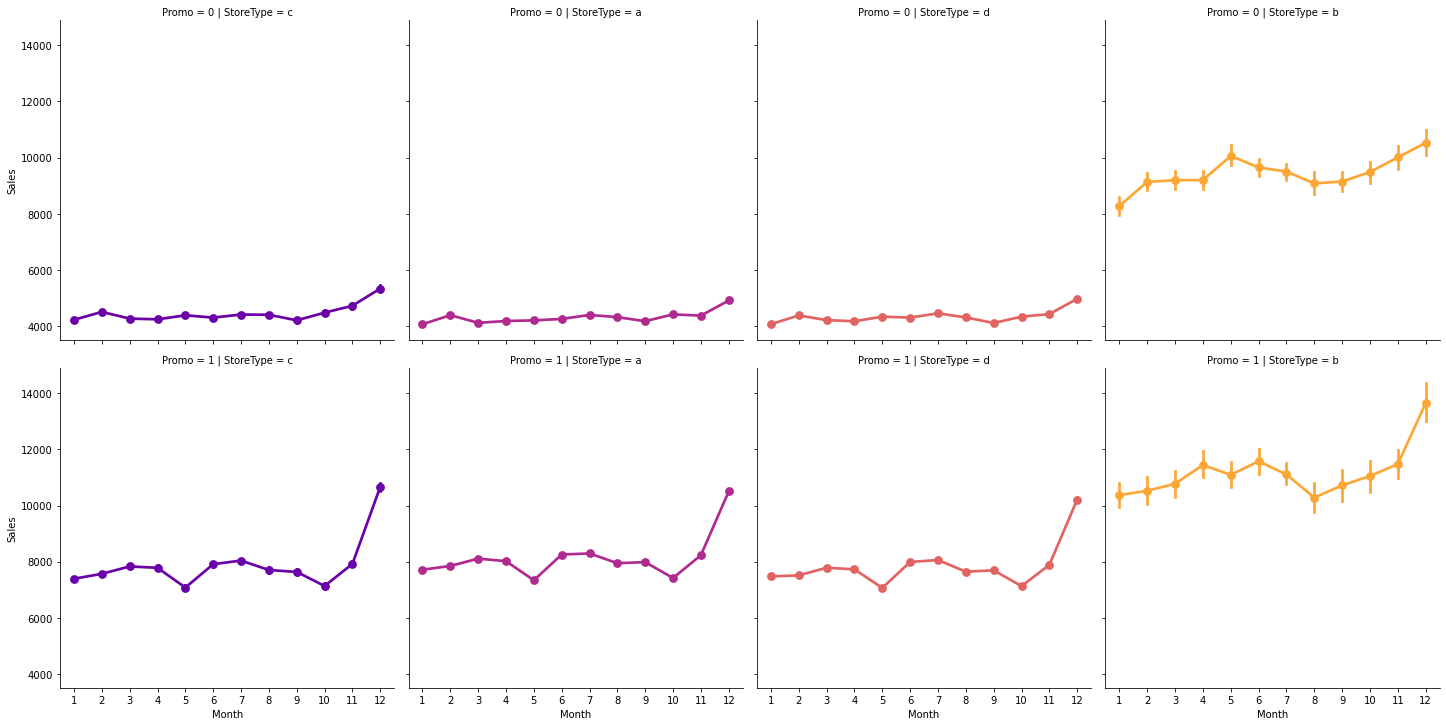

In [75]:
# sales trends for each storeType depending on if there is promotion or not 
sns.factorplot(data = train_store, x = 'Month', y = "Sales", 
               col = 'StoreType', # per store type in cols
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo' # per promo in the store in rows
               )

- According to the results above we can see that sales hike up during christmas especially if there is a promotion. 
- Without promotion there is a slight hike compared to the rest of the time.
- Also storeType b has more sales compared to other stores.

In [77]:
train_store.groupby('StoreType')['Customers'].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,551627.0,659.034880,462.930320,0.0,414.0,647.0,890.0,7388.0
b,15830.0,1987.720846,940.088627,0.0,1228.0,1820.0,2732.0,5494.0
c,136840.0,673.265894,430.708776,0.0,455.0,682.0,924.0,3096.0
d,312912.0,501.434892,292.301770,0.0,375.0,530.0,681.0,2239.0


C:\Users\sahit\Anaconda3\envs\sahithi_ml\lib\site-packages\seaborn\categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


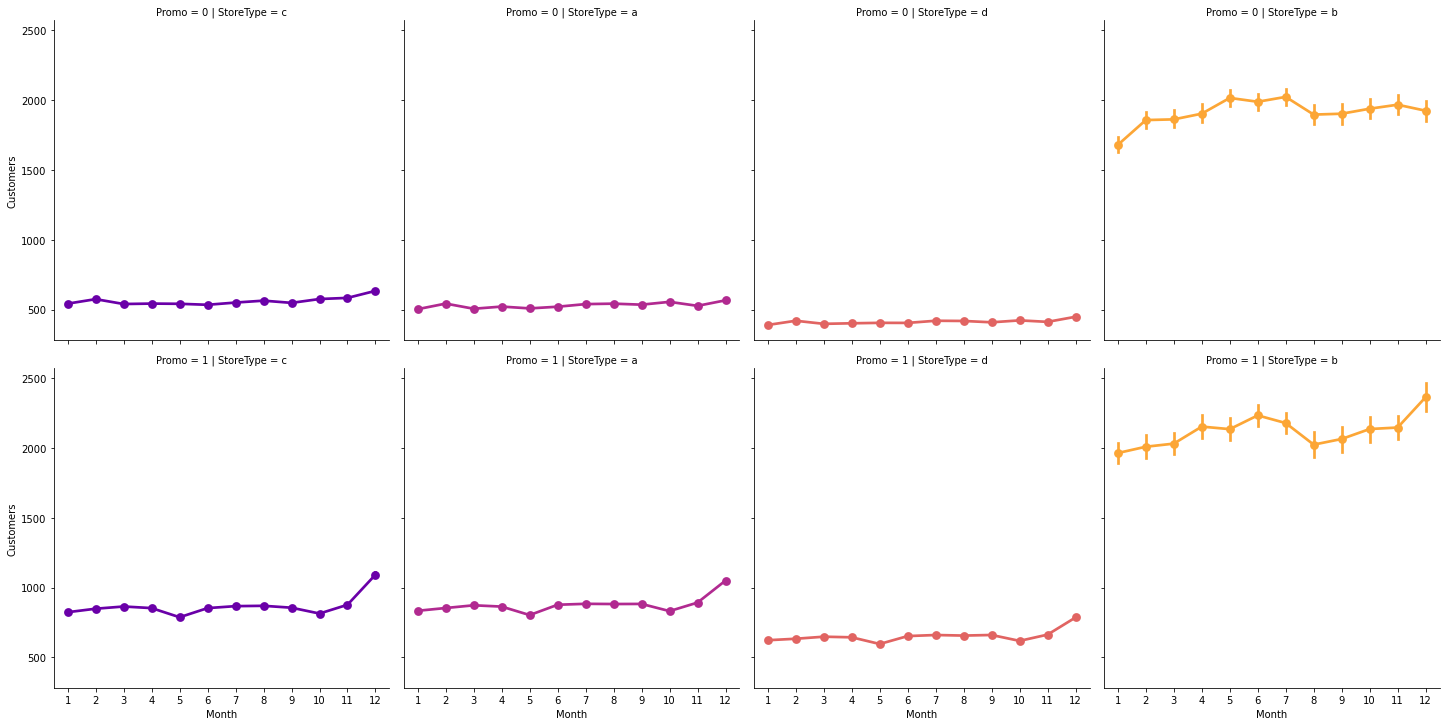

In [78]:
# sales trends
sns.factorplot(data = train_store, x = 'Month', y = "Customers", 
               col = 'StoreType', # per store type in cols
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo' # per promo in the store in rows
               )

- There are more customers for store b compared to other stores.
- Similarly more customers during christmas if there is a promotion.
- Without promotion the there are more or less same number of customer through out the year for storeTpye a, c and d


In [80]:
train_store.groupby('StoreType')['SalesPerCustomer'].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,551627.0,7.329461,3.672402,0.0,6.805664,8.205339,9.592742,29.877551
b,15830.0,5.045870,1.409784,0.0,4.009505,4.947420,6.085210,9.203528
c,136840.0,7.121365,3.617551,0.0,6.624305,8.000357,9.334980,64.957854
d,312912.0,9.326423,4.634349,0.0,8.738610,10.669221,12.236648,57.614983


C:\Users\sahit\Anaconda3\envs\sahithi_ml\lib\site-packages\seaborn\categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


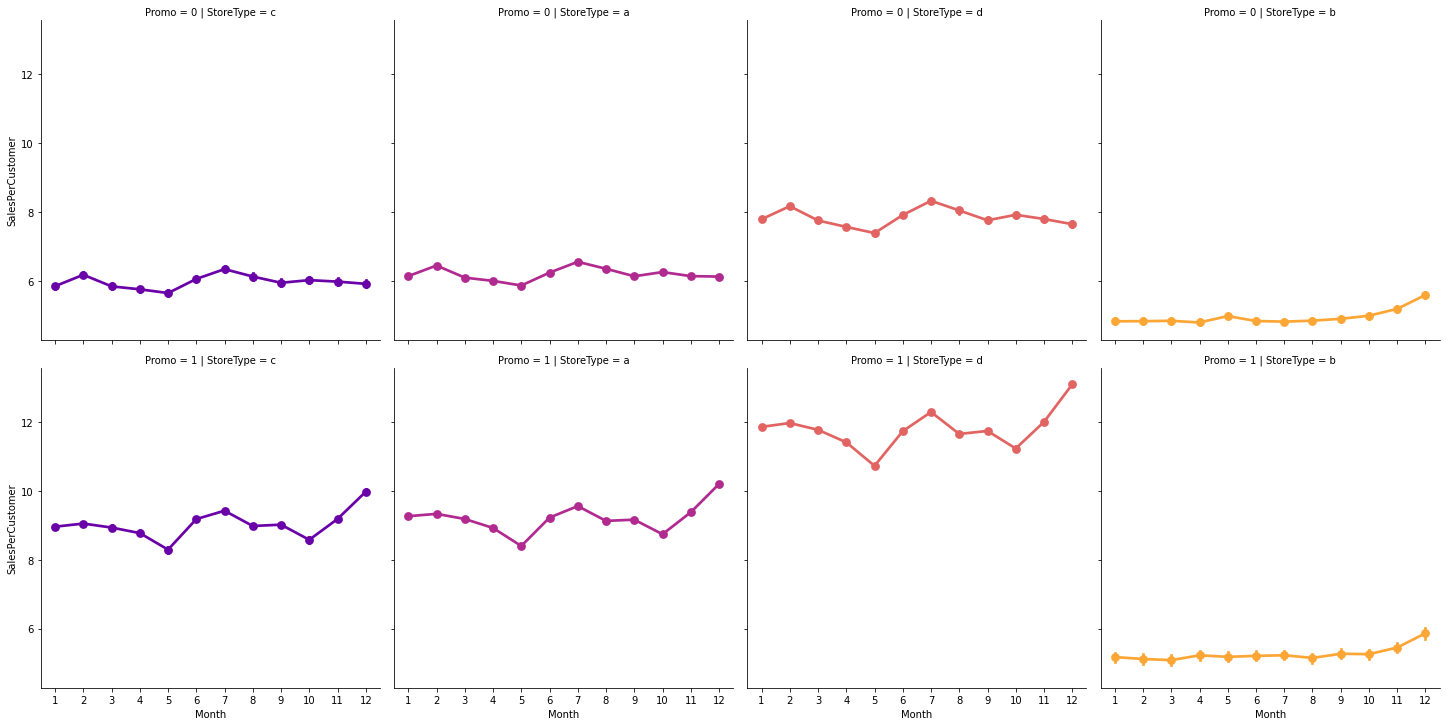

In [81]:
# sales trends
sns.factorplot(data = train_store, x = 'Month', y = "SalesPerCustomer", 
               col = 'StoreType', # per store type in cols
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo' # per promo in the store in rows
               )

- As we can see from the above result, storeType d has more salesPerCustomers. 
- StoreType b has more customers and sales, but less salespercustomer value which means people come to buy small things or less quantity.
- StoreType d has an average of 12 dollars with promotion and around 11 dollars without promotion
- StoreType a and c have a maximum of around 10 dollars during promotion and 6 dollars without promotion

In [83]:
train_store.groupby('Assortment')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
Assortment,,,,,,,,
a,537445.0,5481.026096,3682.766186,0.0,3492.0,5463.0,7514.00,38722.0
b,8294.0,8553.931999,3882.418206,0.0,5523.0,8026.5,11233.25,22137.0
c,471470.0,6058.676567,3992.255662,0.0,4017.0,6039.0,8184.00,41551.0


In [84]:
train_store.groupby('Assortment')['SalesPerCustomer'].describe()

,count,mean,std,min,25%,50%,75%,max
Assortment,,,,,,,,
a,537445.0,7.558109,3.891360,0.0,6.777056,8.334711,9.991150,57.614983
b,8294.0,4.121054,0.752622,0.0,3.700630,4.070811,4.520541,7.367793
c,471470.0,8.313561,4.272276,0.0,7.268803,9.217339,11.080871,64.957854


In [ ]:
# how is assortment helpful?

C:\Users\sahit\Anaconda3\envs\sahithi_ml\lib\site-packages\seaborn\categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


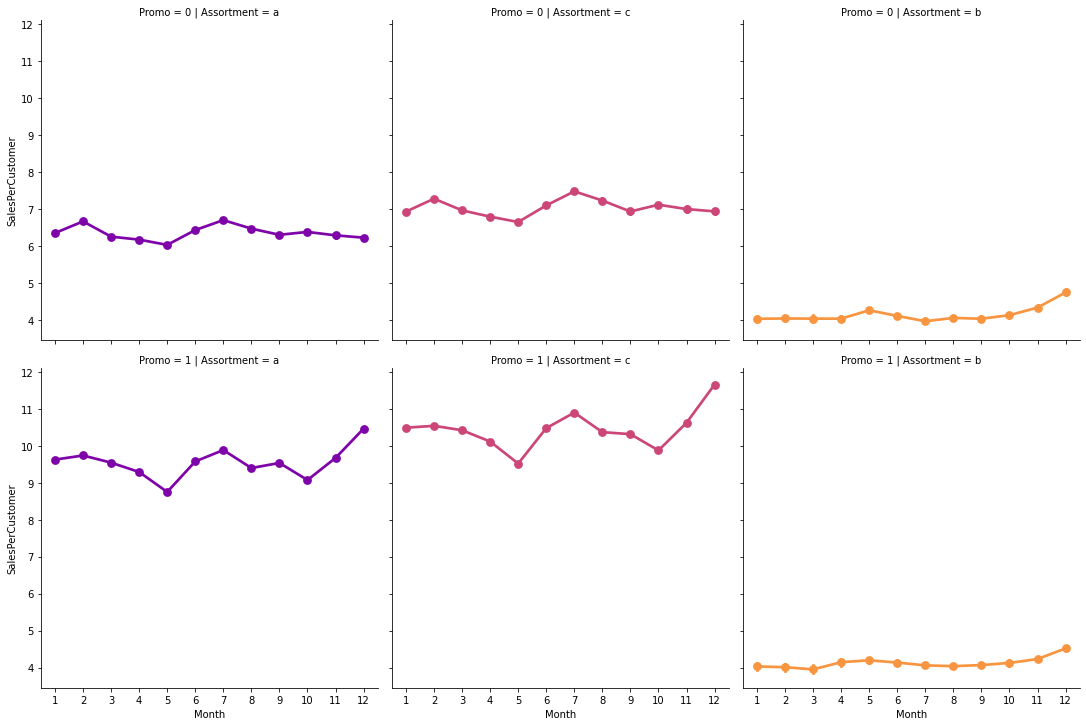

In [85]:
# sales trends
sns.factorplot(data = train_store, x = 'Month', y = "SalesPerCustomer", 
               col = 'Assortment', # per store type in cols
               palette = 'plasma',
               hue = 'Assortment',
               row = 'Promo' # per promo in the store in rows
               )

In [86]:
train_store.groupby('DayOfWeek')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
DayOfWeek,,,,,,,,
1,144730.0,7809.044510,4016.526273,0.0,5235.00,7310.0,9972.0,41551.0
2,145664.0,7005.244467,3142.039607,0.0,4904.00,6463.0,8491.0,34692.0
3,145665.0,6555.884138,2944.377501,0.0,4718.00,6133.0,7926.0,33151.0
4,145845.0,6247.575913,3209.806360,0.0,4536.00,6020.0,7792.0,38367.0
5,145845.0,6723.274305,3101.006008,0.0,4975.00,6434.0,8206.0,38722.0
6,144730.0,5847.562599,2873.985615,0.0,3899.25,5410.0,7220.0,31683.0
7,144730.0,204.183189,1613.243517,0.0,0.00,0.0,0.0,37376.0


C:\Users\sahit\Anaconda3\envs\sahithi_ml\lib\site-packages\seaborn\categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


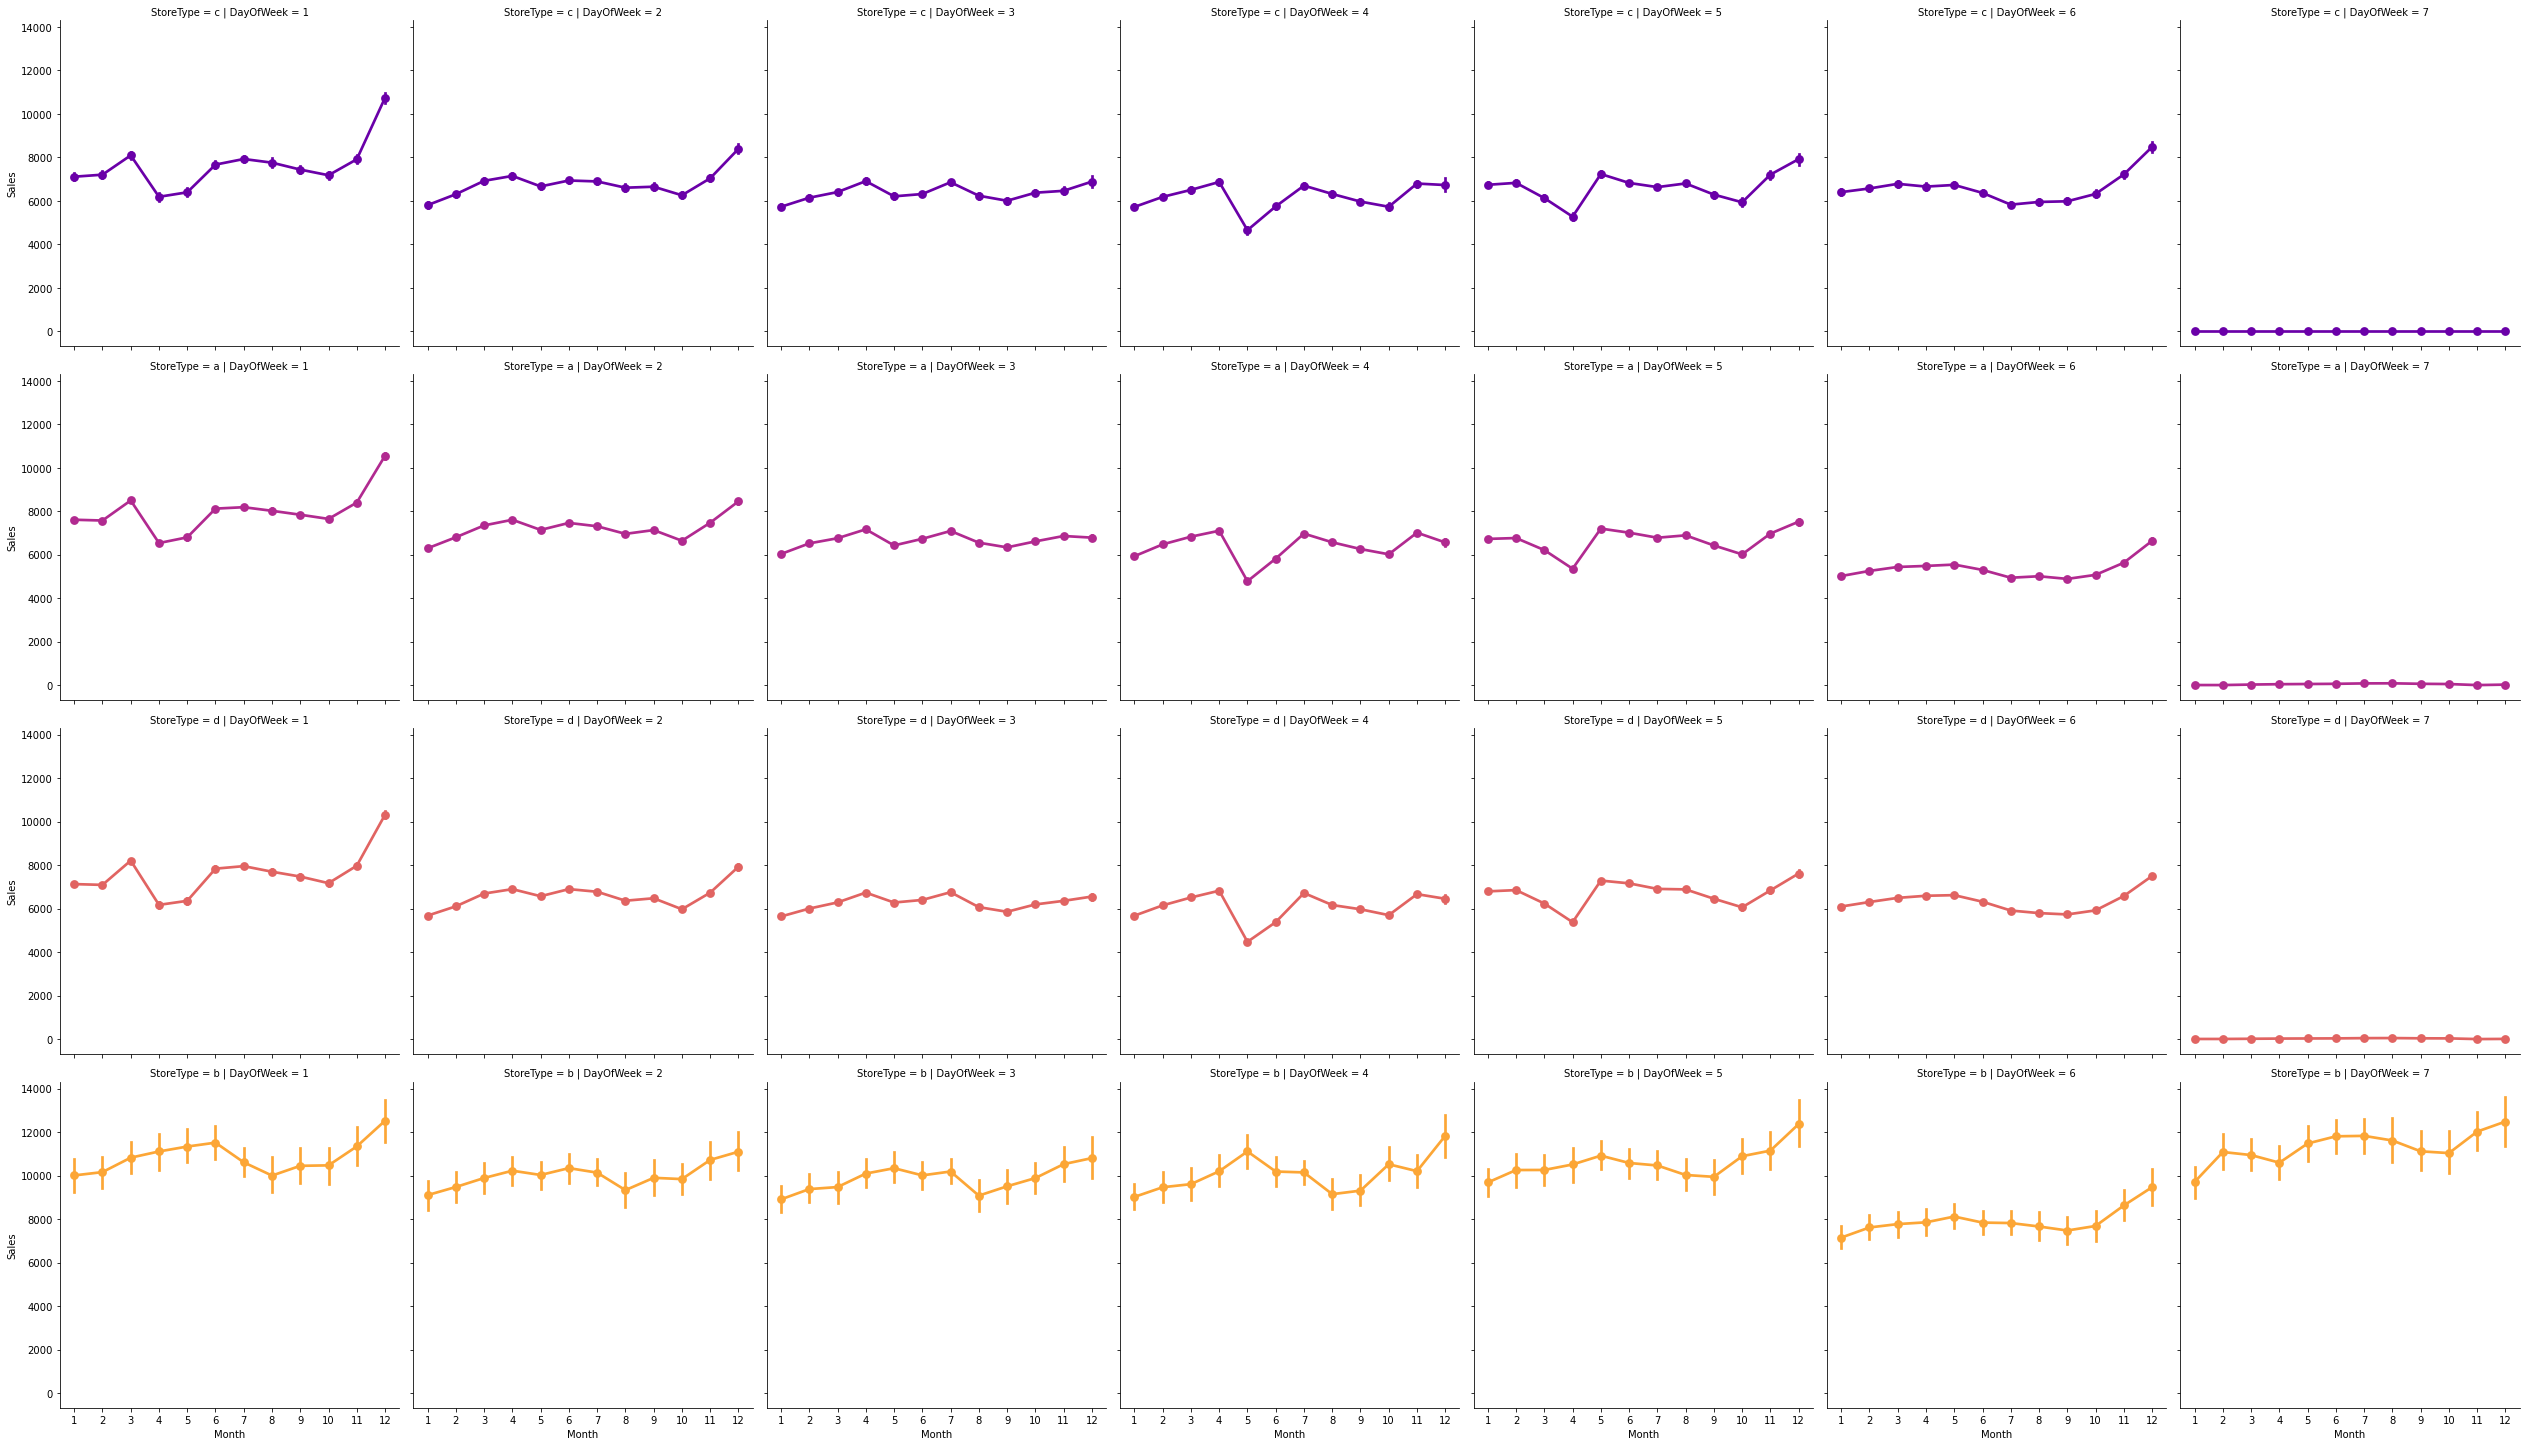

In [87]:
sns.factorplot(data = train_store, x = 'Month', y = "Sales", 
               col = 'DayOfWeek', # per dayofweek type in cols
               palette = 'plasma',
               hue = 'StoreType',
               row = 'StoreType' # per store type in rows
              )

- StoreType a,c,d are closed on sundays as the sales are zero.
- storeType b has more sales. On Saturdays it has less sales compared to the other days of the week.


C:\Users\sahit\Anaconda3\envs\sahithi_ml\lib\site-packages\seaborn\categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


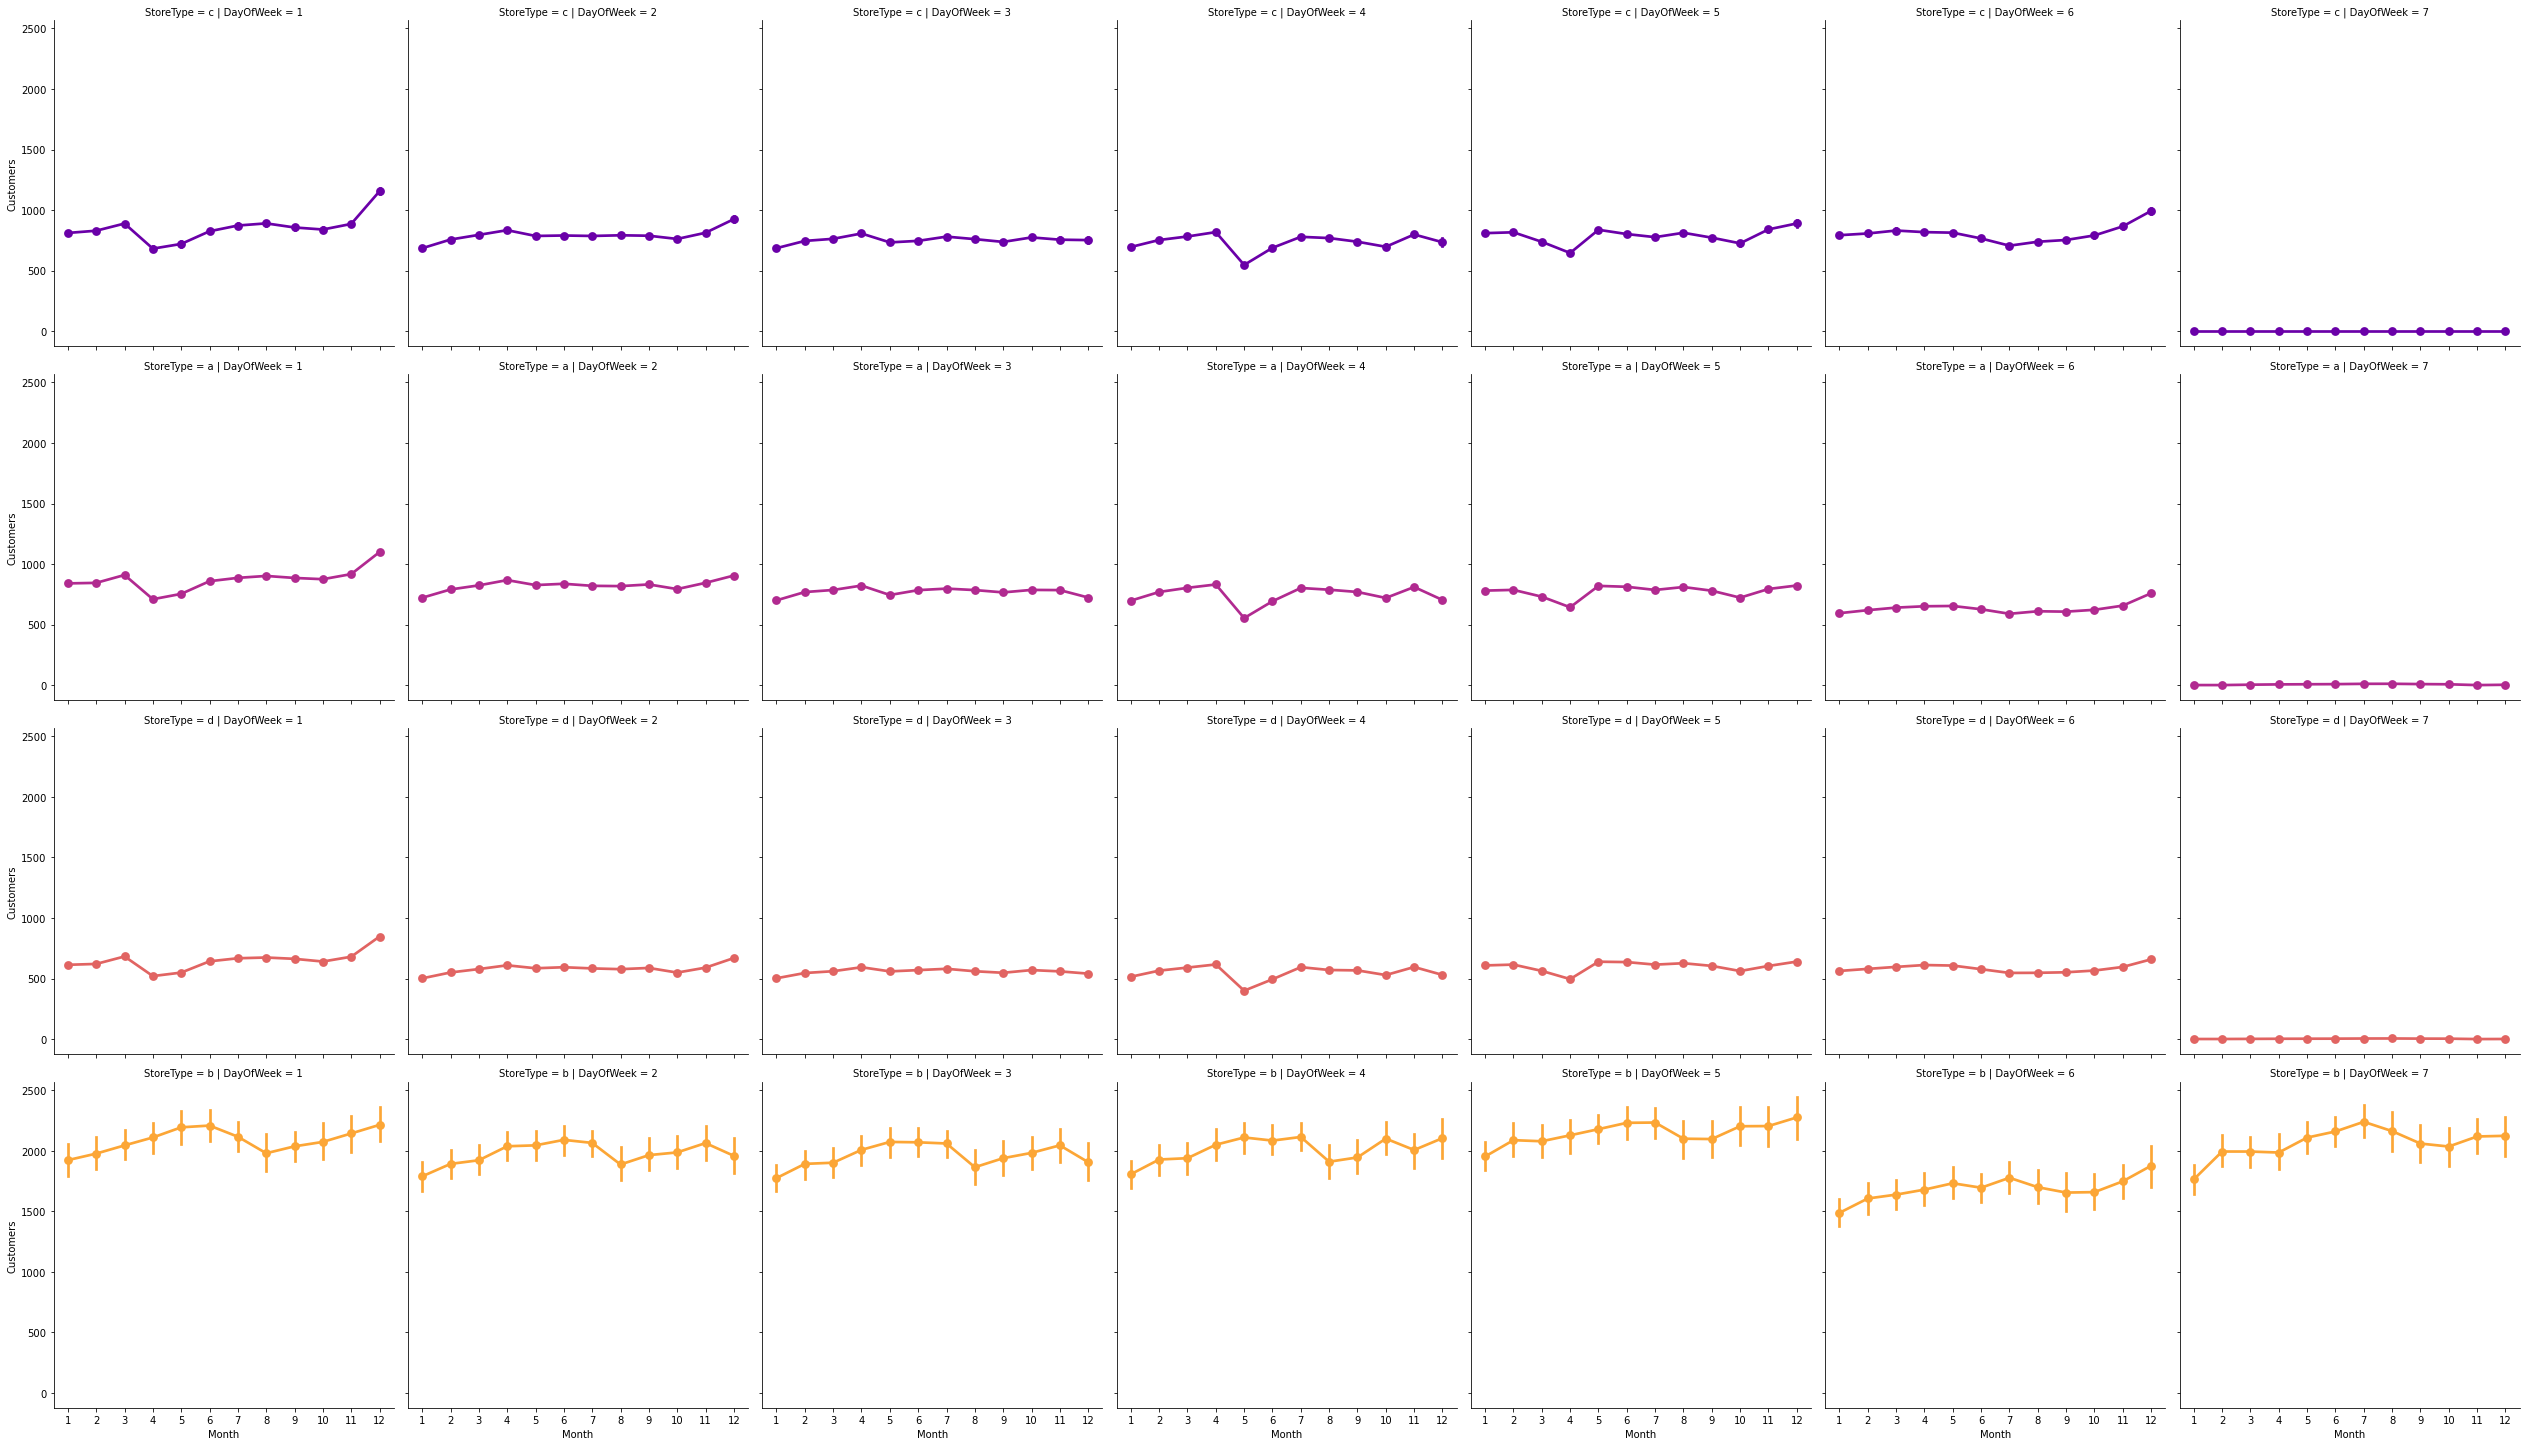

In [93]:
sns.factorplot(data = train_store, x = 'Month', y = "Customers", 
               col = 'DayOfWeek', # per dayofweek type in cols
               palette = 'plasma',
               hue = 'StoreType',
               row = 'StoreType' # per store type in rows
              )

- StoreType a,c,d are closed on sundays as the number of customers are zero.
- storetype b has more customers and less number of customers on Saturday compared to other days.

C:\Users\sahit\Anaconda3\envs\sahithi_ml\lib\site-packages\seaborn\categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


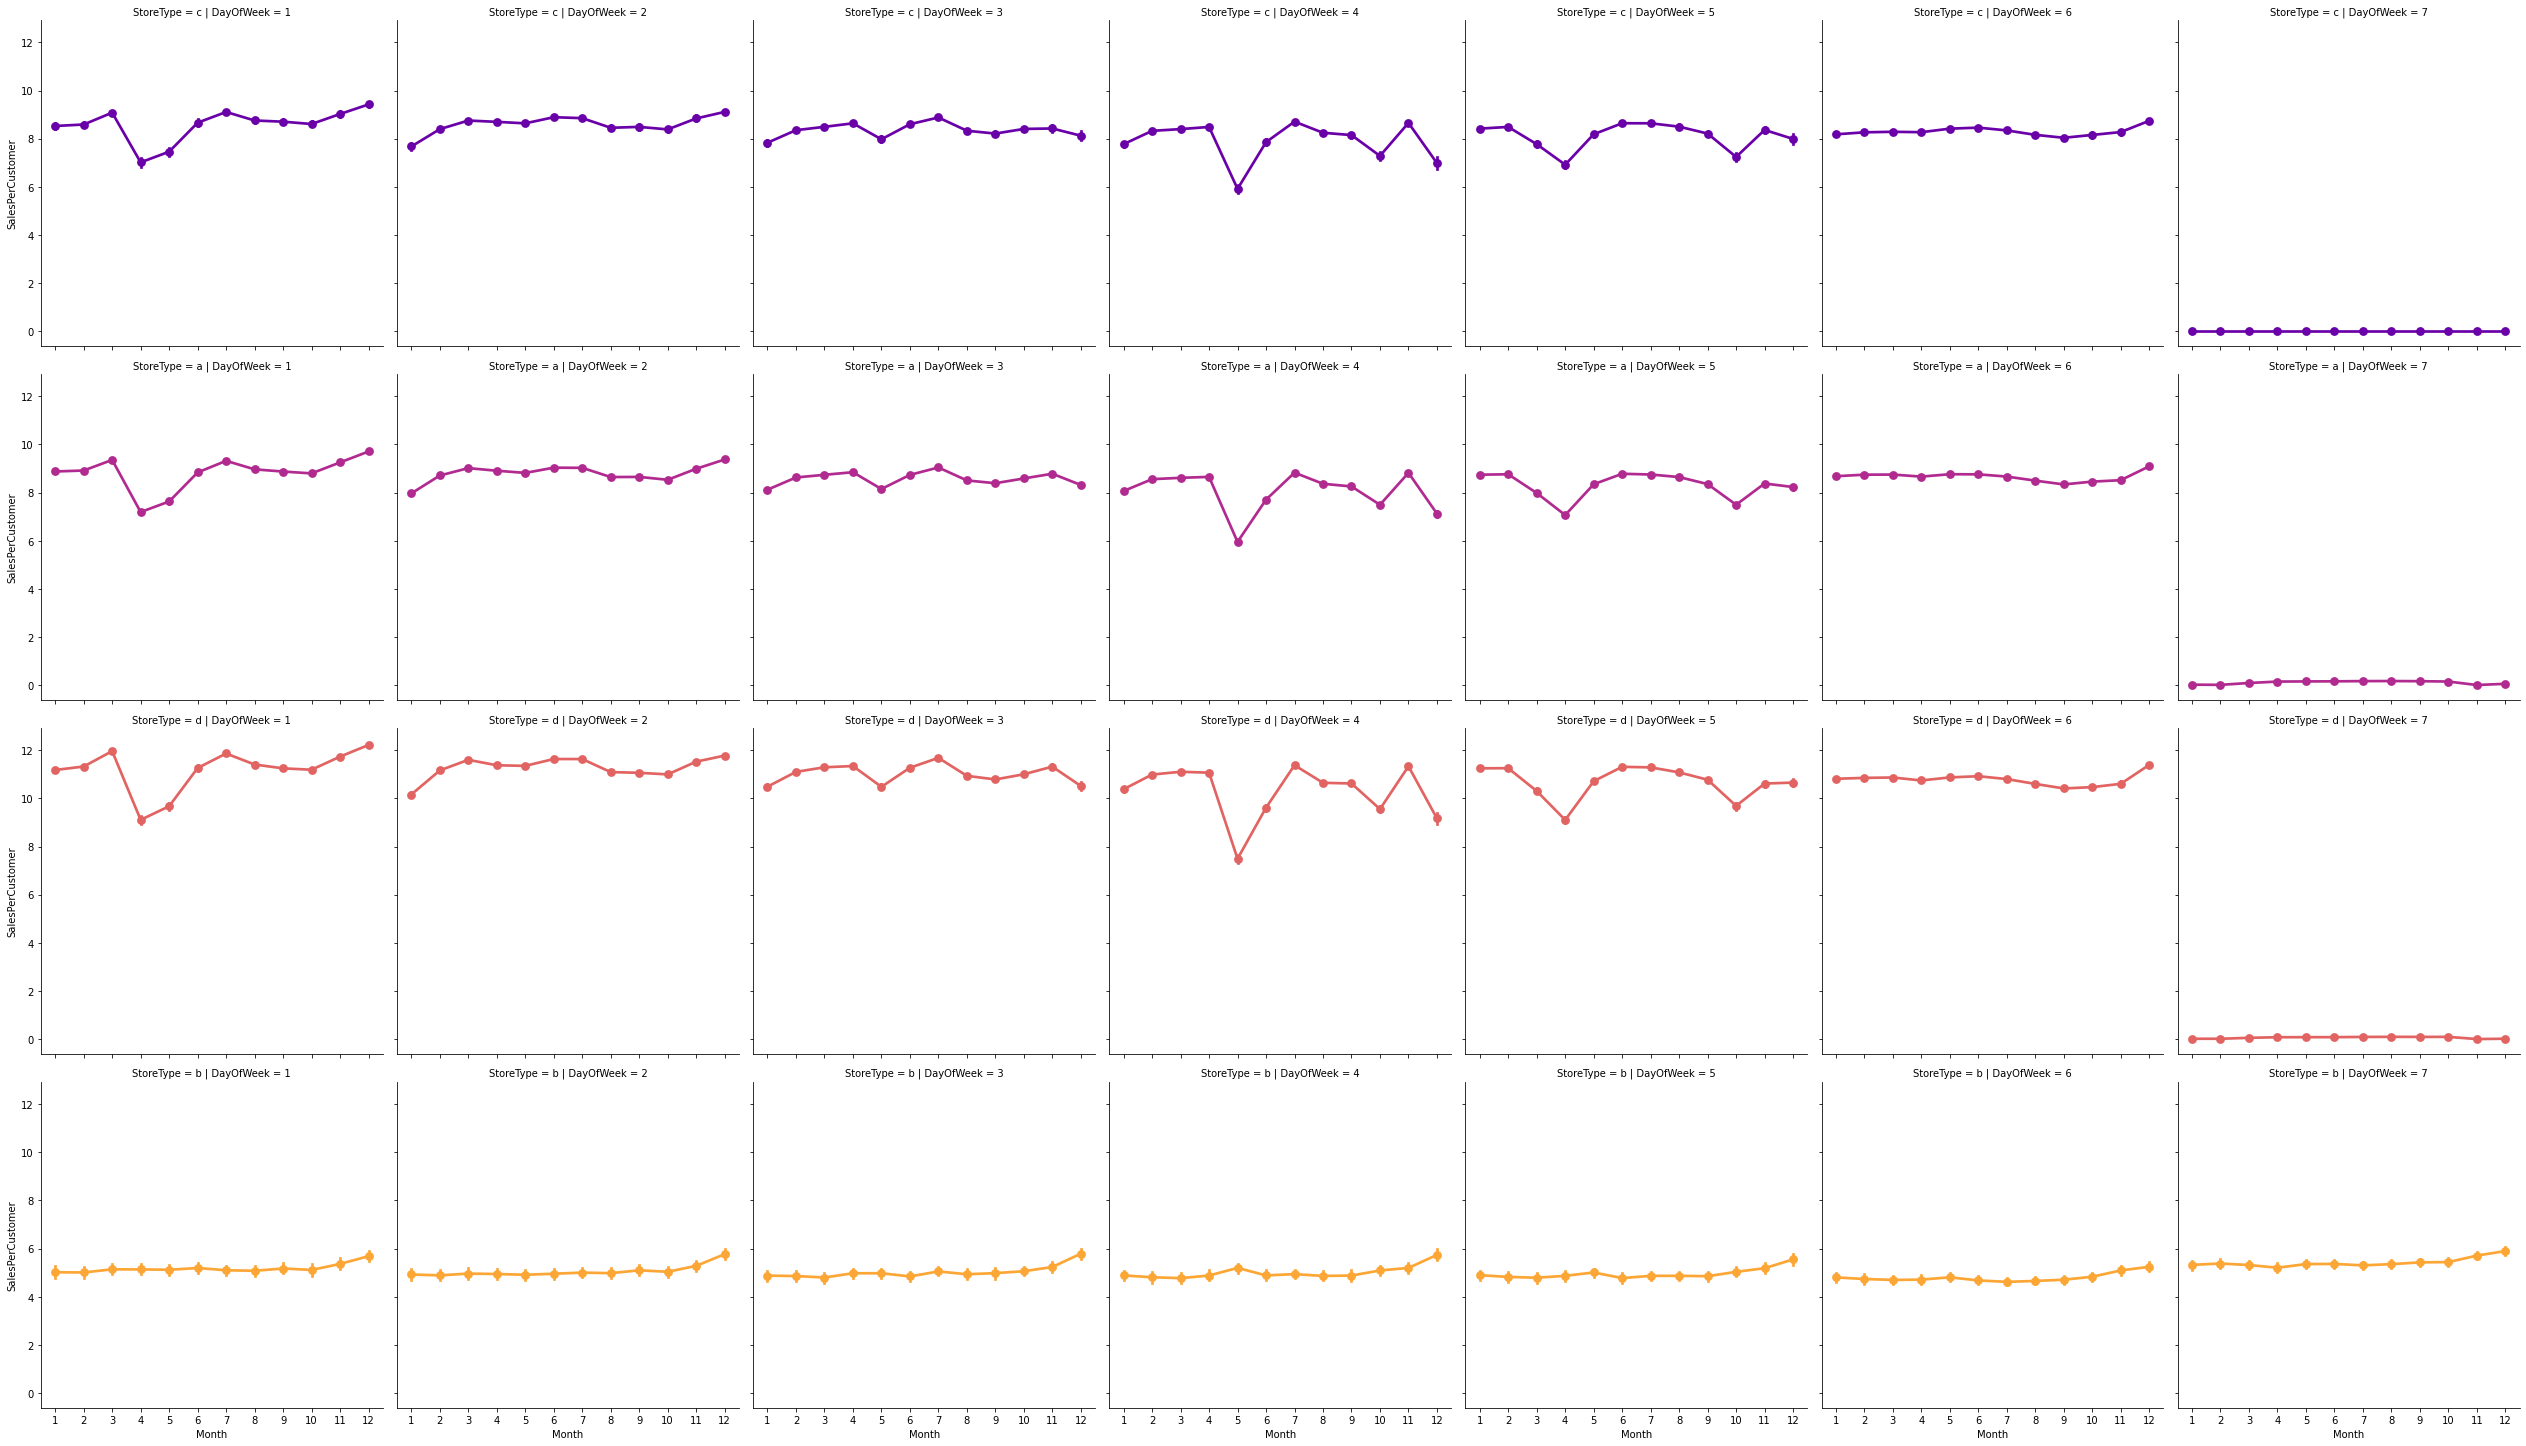

In [95]:
# SalesPerCustomer depending on Day of the week.
sns.factorplot(data = train_store, x = 'Month', y = "SalesPerCustomer", 
               col = 'DayOfWeek', # per dayofweek type in cols
               palette = 'plasma',
               hue = 'StoreType',
               row = 'StoreType' # per store type in rows
              )

- StoreType d has more salesPerCustomer value followed by a and c

In [102]:
train_store.groupby('SchoolHoliday')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
SchoolHoliday,,,,,,,,
0,835488.0,5620.979034,3862.873159,0.0,3506.0,5642.0,7749.0,41551.0
1,181721.0,6476.522207,3709.677337,0.0,4447.0,6197.0,8343.0,38367.0


C:\Users\sahit\Anaconda3\envs\sahithi_ml\lib\site-packages\seaborn\categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


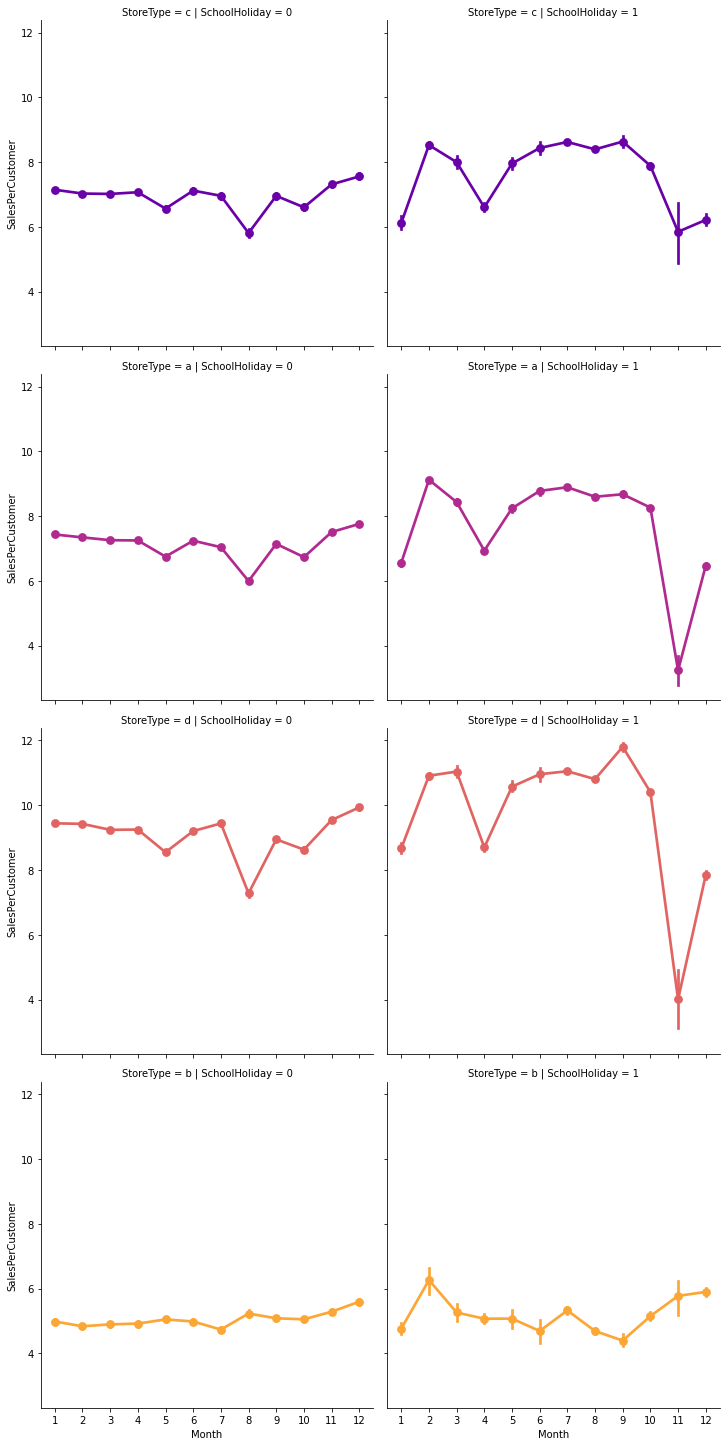

In [103]:
# Sales depending on SchoolHolidays
sns.factorplot(data = train_store, x = 'Month', y = "SalesPerCustomer", 
               col = 'SchoolHoliday', # per dayofweek type in cols
               palette = 'plasma',
               hue = 'StoreType',
               row = 'StoreType' # per store type in rows
              )

C:\Users\sahit\Anaconda3\envs\sahithi_ml\lib\site-packages\seaborn\categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


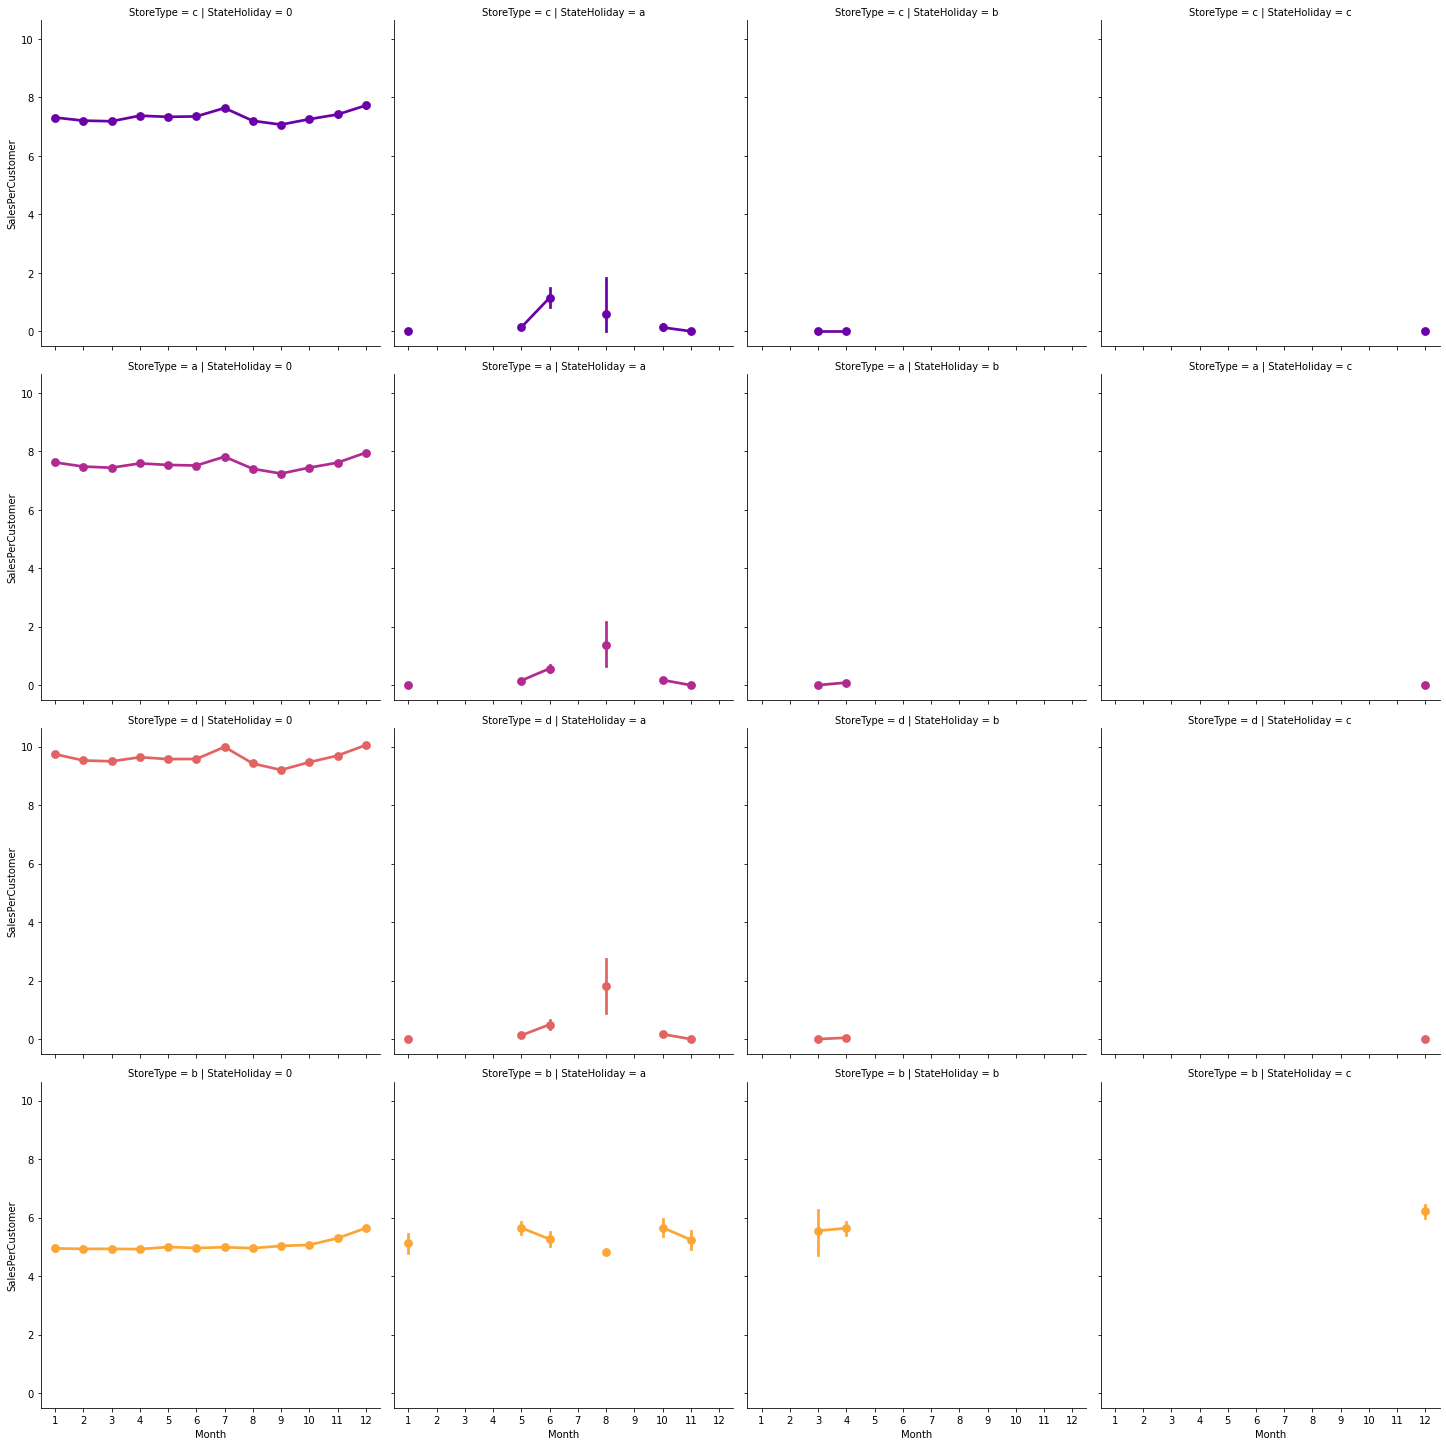

In [104]:
# SalesPerCustomer depending on StateHolidays
sns.factorplot(data = train_store, x = 'Month', y = "SalesPerCustomer", 
               col = 'StateHoliday', # per dayofweek type in cols
               palette = 'plasma',
               hue = 'StoreType',
               row = 'StoreType' # per store type in rows
              )

C:\Users\sahit\Anaconda3\envs\sahithi_ml\lib\site-packages\seaborn\categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


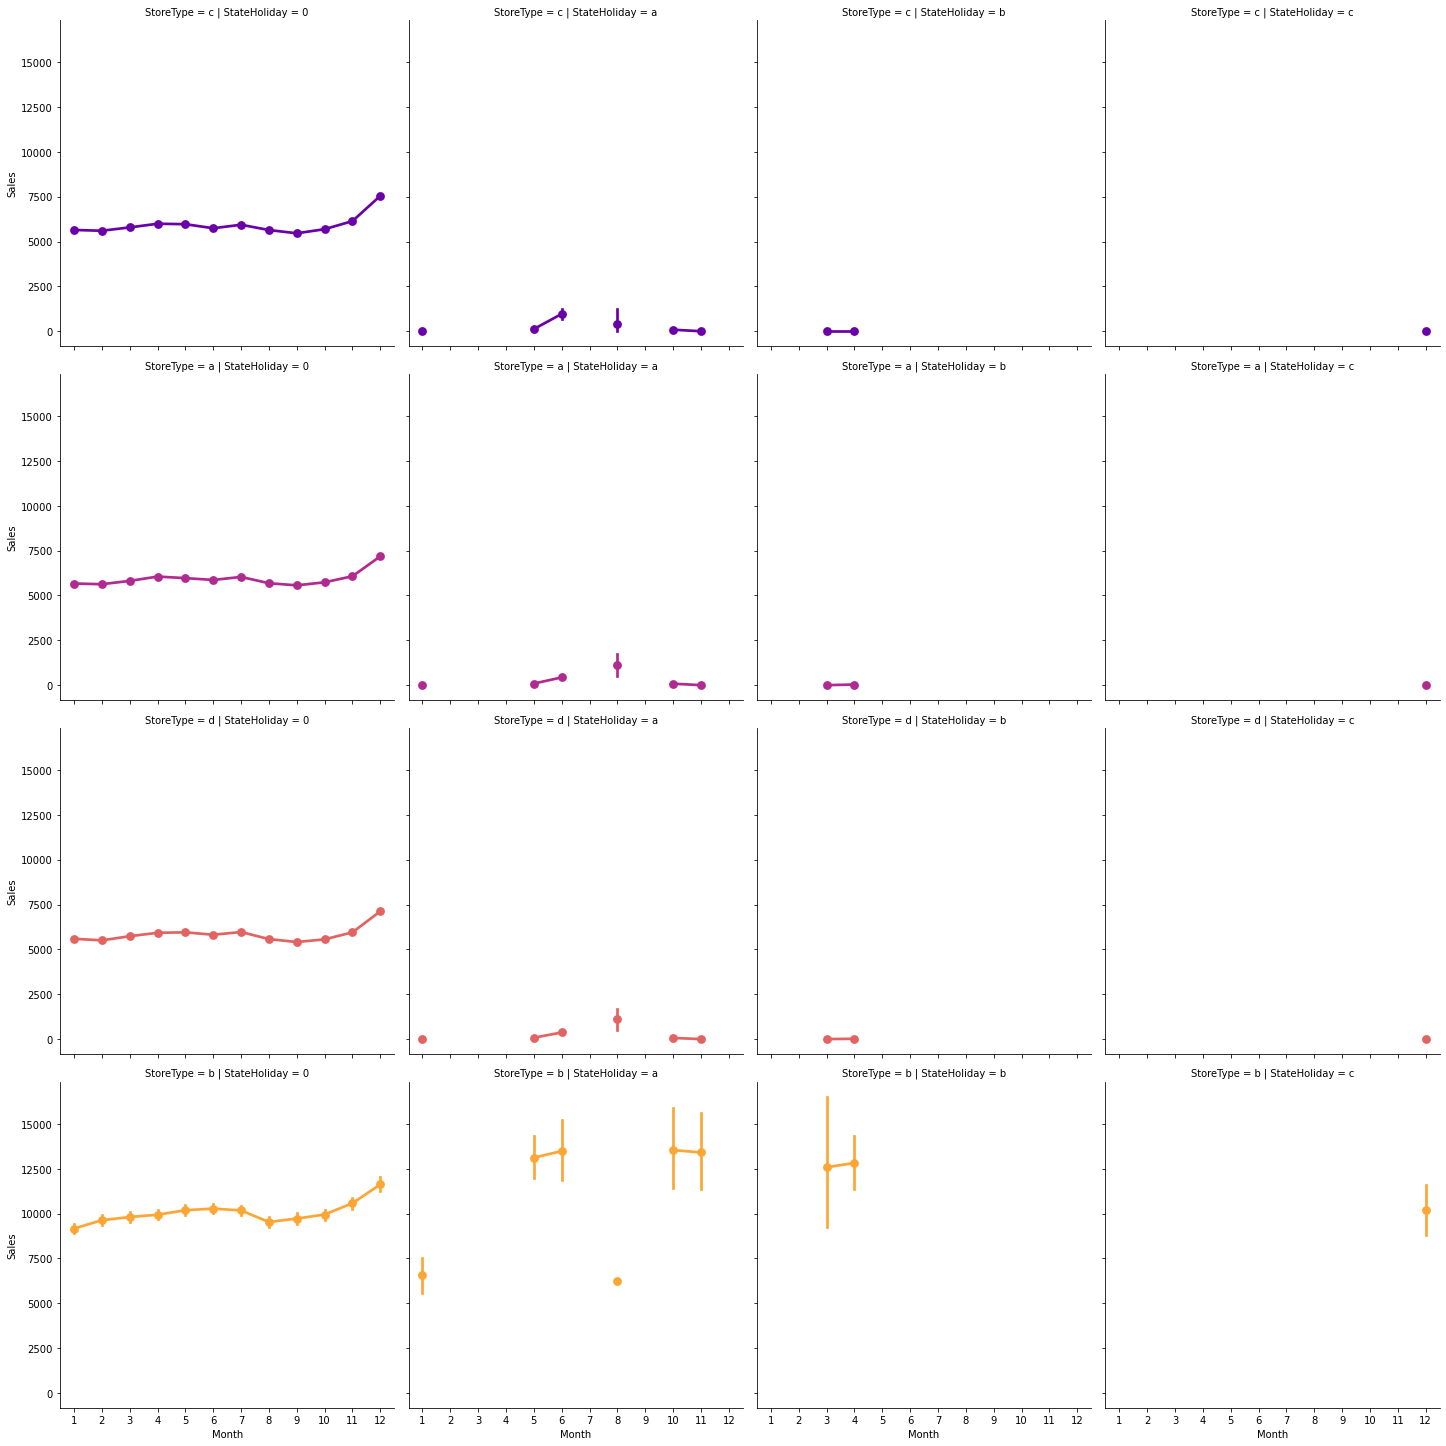

In [105]:
# Sales depending on StateHolidays
sns.factorplot(data = train_store, x = 'Month', y = "Sales", 
               col = 'StateHoliday', # per dayofweek type in cols
               palette = 'plasma',
               hue = 'StoreType',
               row = 'StoreType' # per store type in rows
              )

- storeTypes a, c, d are closed for Christmas, Easter and some public holidays while storeType b is open on most of the days.


<AxesSubplot:>

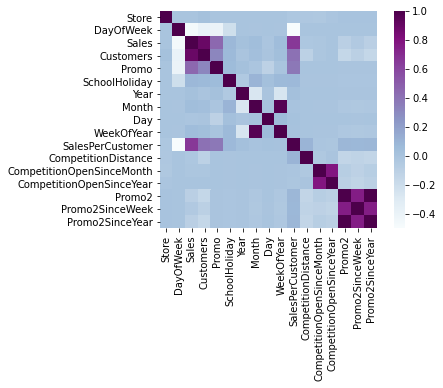

In [115]:
# correlation analysis
corr_all = train_store.drop('Open', axis = 1).corr()
sns.heatmap(corr_all,
            square = True, cmap = "BuPu") 

C:\Users\sahit\Anaconda3\envs\sahithi_ml\lib\site-packages\seaborn\categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


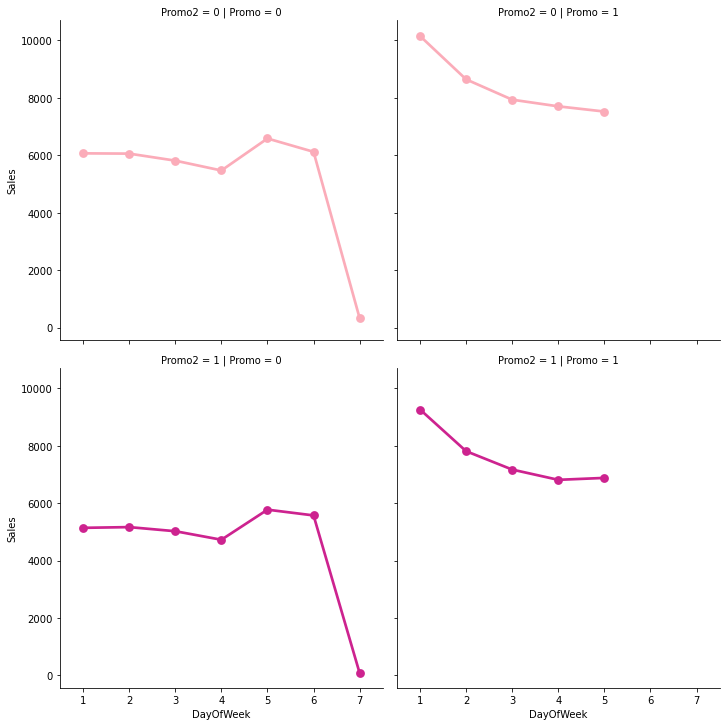

In [116]:
# sales per customer trends depending on promtions
sns.factorplot(data = train_store, x = 'DayOfWeek', y = "Sales", 
               col = 'Promo', 
               row = 'Promo2',
               hue = 'Promo2',
               palette = 'RdPu') 

C:\Users\sahit\Anaconda3\envs\sahithi_ml\lib\site-packages\seaborn\categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


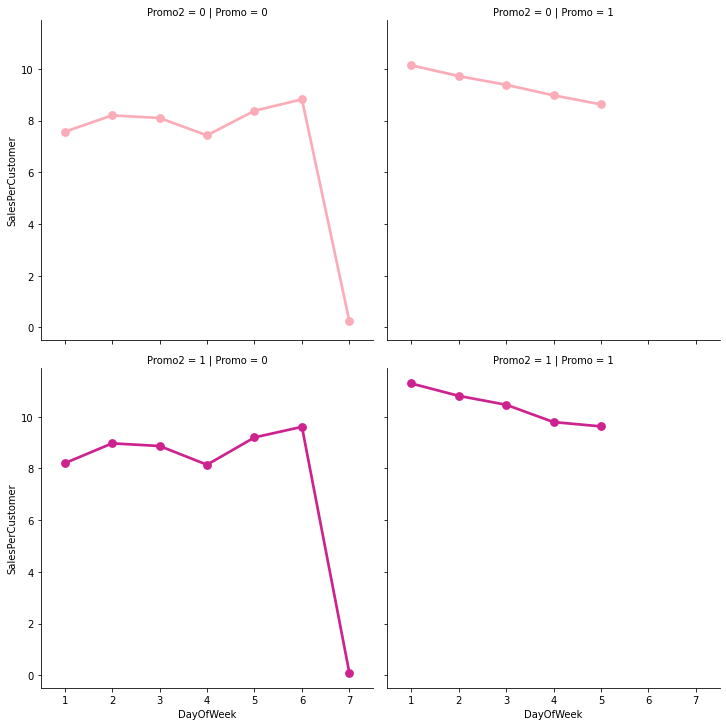

In [117]:
# sale per customer trends
sns.factorplot(data = train_store, x = 'DayOfWeek', y = "SalesPerCustomer", 
               col = 'Promo', 
               row = 'Promo2',
               hue = 'Promo2',
               palette = 'RdPu') 

- when there is a promotion the sales are maximum on Monday.

In [ ]:
# relation between sales and competition ??

#### EDA
- Store type b has more sales and more customers, but less salesPerCustomer value. this means people often visit this store for buying small things (less quantity).
- store type d has more salesPerCustomer value. it has a high buyer cart. the store can include a larger vareity of products.
- store a, c, d are closed on sundays, easter , christmas and some public holidays.
- store b is open on most of the days including sundays, christmas and easter.
- Mondays have maximum sales if there is a promotion.
- promo2 doesn't alone contribute much to the sales value.

### Time Series Analysis
- Trend
- Seasonality 
- autocorrelation
- stationarity ?

In [168]:
# merge the datasets based on store and index it on date-time series
train2 = pd.read_csv(r"C:\Sahithi\case study\take_home_task_(3)\train.csv")
# merge datasets
train_store2 = pd.merge(train2, store, how = 'inner', on = 'Store')
#index the dataset on date-time series
train_store2.set_index(['Date'], inplace=True)
train_store2.index = pd.to_datetime(train_store2.index)
train_store2['Year'] = train_store2.index.year
train_store2['Month'] = train_store2.index.month
train_store2['Day'] = train_store2.index.day
train_store2['WeekOfYear'] = train_store2.index.weekofyear
train_store2.head()

<ipython-input-168-80d2b766f2a8>:9: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  train_store2['WeekOfYear'] = train_store2.index.weekofyear


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,...,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear
Date,,,,,,,,,,,,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,c,a,...,9.0,2008.0,0,0.0,0.0,0,2015,7,31,31
2015-07-30,1,4,5020,546,1,1,0,1,c,a,...,9.0,2008.0,0,0.0,0.0,0,2015,7,30,31
2015-07-29,1,3,4782,523,1,1,0,1,c,a,...,9.0,2008.0,0,0.0,0.0,0,2015,7,29,31
2015-07-28,1,2,5011,560,1,1,0,1,c,a,...,9.0,2008.0,0,0.0,0.0,0,2015,7,28,31
2015-07-27,1,1,6102,612,1,1,0,1,c,a,...,9.0,2008.0,0,0.0,0.0,0,2015,7,27,31


In [147]:
train_store2.isnull().sum()

Store                        0
DayOfWeek                    0
Sales                        0
Customers                    0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

<AxesSubplot:xlabel='Date'>

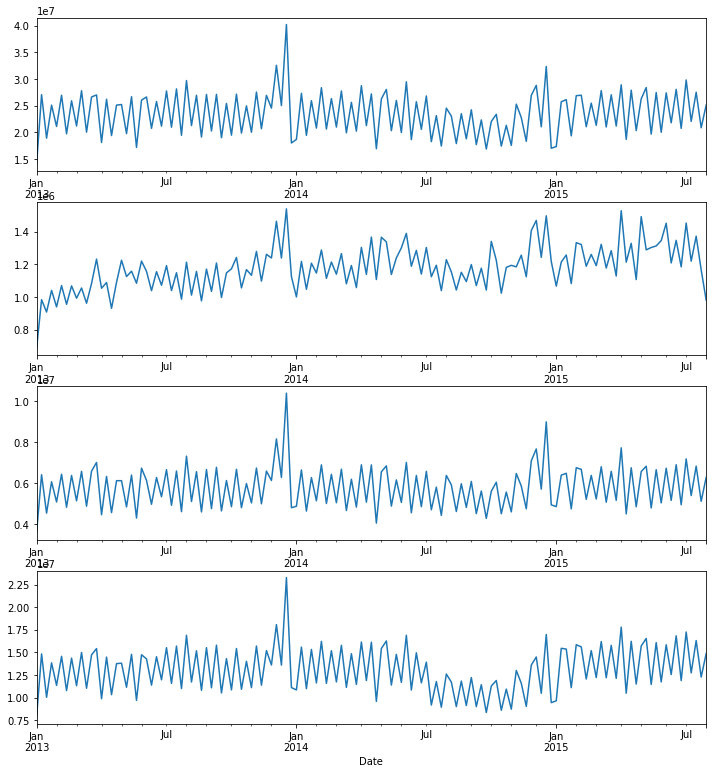

In [172]:
# preparation: input should be float type
train_store2['Sales'] = train_store2['Sales'] * 1.0

sales_a = train_store2[train_store2.StoreType == 'a']['Sales'] 
sales_b = train_store2[train_store2.StoreType == 'b']['Sales'] 
sales_c = train_store2[train_store2.StoreType == 'c']['Sales'] 
sales_d = train_store2[train_store2.StoreType == 'd']['Sales']
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))

# seasonality for the store types 
sales_a.resample('W').sum().plot( ax = ax1)
sales_b.resample('W').sum().plot( ax = ax2)
sales_c.resample('W').sum().plot( ax = ax3)
sales_d.resample('W').sum().plot( ax = ax4)

- StoreType a and c follow a similar trend over time. 
- Sales hike up during christmas, expecially during 2013 christmas in all stores.

<ipython-input-173-1aa205a30bcf>:5: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  decomposition_a = seasonal_decompose(sales_a, model = 'additive', freq = 365)
<ipython-input-173-1aa205a30bcf>:8: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  decomposition_b = seasonal_decompose(sales_b, model = 'additive', freq = 365)
<ipython-input-173-1aa205a30bcf>:11: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  decomposition_c = seasonal_decompose(sales_c, model = 'additive', freq = 365)
<ipython-input-173-1aa205a30bcf>:14: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  decomposition_d = seasonal_decompose(sales_d, model = 'additive', freq = 365)


<AxesSubplot:xlabel='Date'>

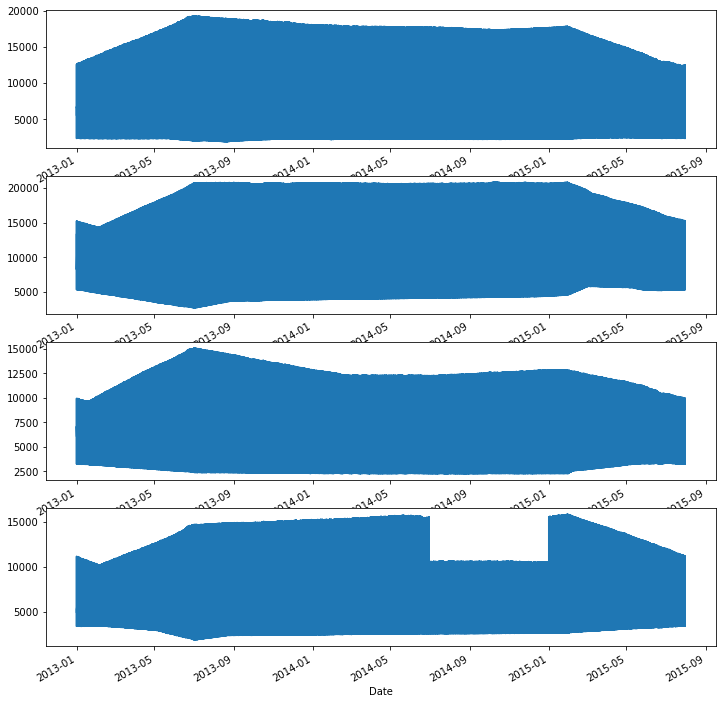

In [173]:
# checking the trend and seasonality
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))

# monthly
decomposition_a = seasonal_decompose(sales_a, model = 'additive', freq = 365)
decomposition_a.trend.plot( ax = ax1)

decomposition_b = seasonal_decompose(sales_b, model = 'additive', freq = 365)
decomposition_b.trend.plot( ax = ax2)

decomposition_c = seasonal_decompose(sales_c, model = 'additive', freq = 365)
decomposition_c.trend.plot( ax = ax3)

decomposition_d = seasonal_decompose(sales_d, model = 'additive', freq = 365)
decomposition_d.trend.plot( ax = ax4)


- what to infer from the above graph?
- is there any way to plot it in more understandable way?

### Auto-correlation

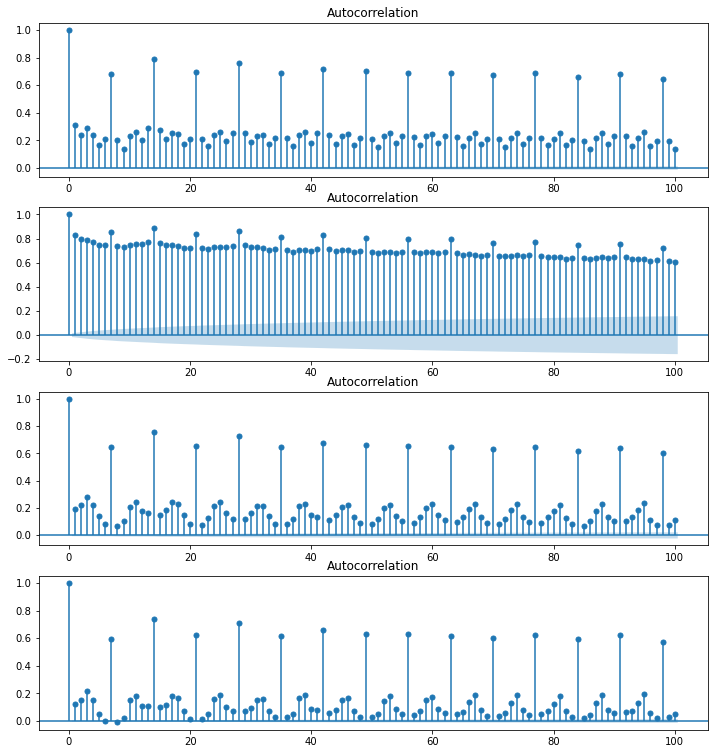

In [185]:
# figure for subplots
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))

# acf for A
plot_acf(sales_a, lags = 100, ax = ax1)

# acf for B
plot_acf(sales_b, lags = 100, ax = ax2)

# acf for C
plot_acf(sales_c, lags = 100, ax = ax3)

# acf for D
plot_acf(sales_d, lags = 100, ax = ax4)

plt.show()

- Storetype a, c and d have a periodic distribution and the sales hike up every 7 days
- StoreType b has uniform distribution and there is a slight increase in sales every 7 days

## Forecast methods

In [2]:
# check for stationarity
df = pd.read_csv(r"C:\Sahithi\case study\take_home_task_(3)\train.csv",low_memory=False, index_col ='Date', parse_dates=True)
df.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


In [3]:
df = df[(df['Open'] != 0) & (df['Sales'] != 0)]
#df = df[(df['Store'] == 3)] # Should I consider one store or all stores ? 
df.shape

(844338, 8)

<AxesSubplot:xlabel='Date'>

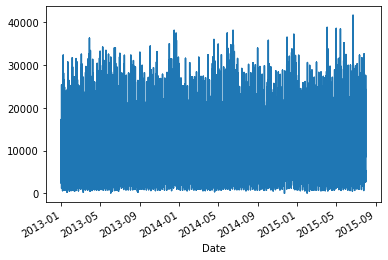

In [4]:
df['Sales'].plot()

In [216]:
sales_ts = df[['Sales', 'Date']]
sales_ts['Date'] = pd.to_datetime(sales_ts['Date'])

<ipython-input-216-5b40e5a59049>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_ts['Date'] = pd.to_datetime(sales_ts['Date'])


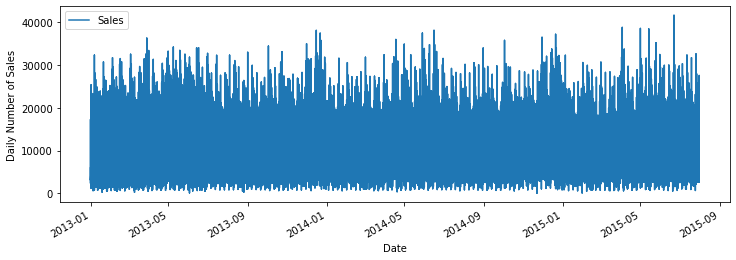

In [217]:
# plot daily sales of all stores 
ax = sales_ts.set_index('Date').plot(figsize = (12, 4))
ax.set_ylabel('Daily Number of Sales')
ax.set_xlabel('Date')
plt.show()

In [246]:
#df.set_index(['Date'], inplace=True)
df.dtypes

Store             int64
DayOfWeek         int64
Sales             int64
Customers         int64
Open              int64
Promo             int64
StateHoliday     object
SchoolHoliday     int64
dtype: object

In [ ]:
stepwise_fit = auto_arima(df['Sales'], trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1012.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=16302515.507, Time=24.59 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=16078333.096, Time=29.91 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=15747405.288, Time=279.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=16302513.507, Time=15.29 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=15747116.055, Time=417.54 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=15746924.243, Time=704.91 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=15991198.471, Time=27.66 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=15746118.510, Time=764.43 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=15933189.519, Time=65.39 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=15758810.135, Time=397.52 sec


In [10]:
X_train = df[:int(df.shape[0]*0.7)]
X_test = df[int(df.shape[0]*0.7):]
print(X_train.shape, X_test.shape)

(591036, 8) (253302, 8)


In [17]:
# fit the ARIMA model
model = ARIMA(df['Sales'], order=(3,1,1))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())

C:\Users\sahit\Anaconda3\envs\sahithi_ml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\sahit\Anaconda3\envs\sahithi_ml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:585: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'
C:\Users\sahit\Anaconda3\envs\sahithi_ml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\sahit\Anaconda3\envs\sahithi_ml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:585: ValueWarning: A date i

MemoryError: Unable to allocate 25.8 MiB for an array with shape (4, 844334) and data type float64

In [ ]:
start = len(X_train)
end = len(X_train) + len(X_test) -1
pred = model_fit.predict(start=start,end=end, typ='levels')
pred.index = df.index[start:end+1]
pred

pred.plot(legend=True)
X_test['Sales'].plot(legend=True)